# Import & Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

# Load DataSet

In [ ]:
df = pd.read_csv('Walmart.csv')
 
 # Top 5
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
#Know Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
#Describe Data
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


# EDA (Exploratory Data Analysis)

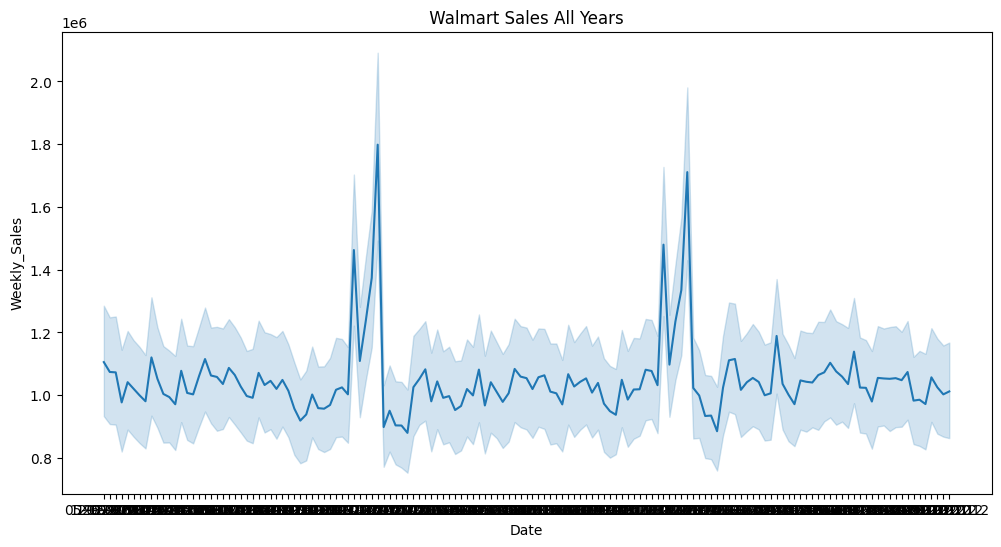

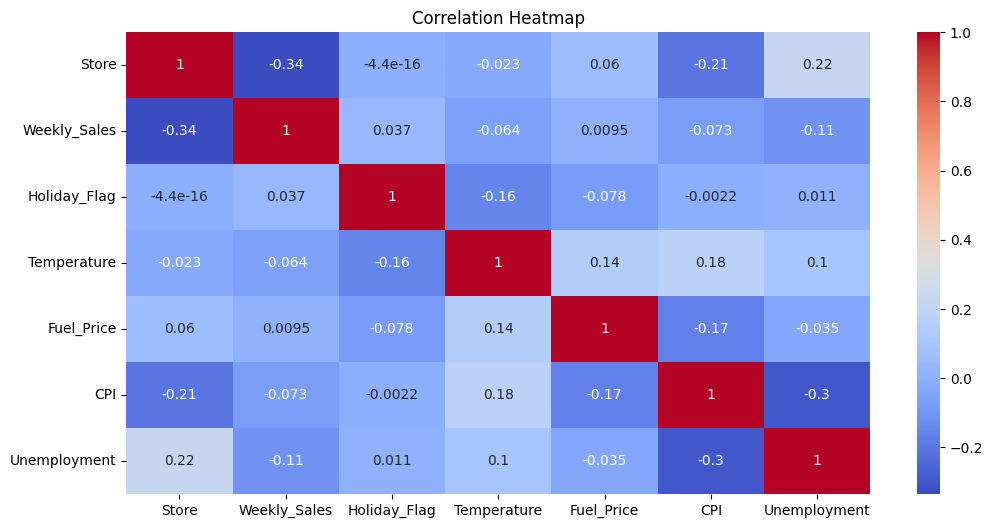

In [11]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Weekly_Sales', data=df)
plt.title(' Walmart Sales All Years ')
plt.savefig("walmart_sales_trend.png", dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(12,6))
numeric_df = df.select_dtypes(include=['float64','int64'])  
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig("Correlation Heatmap.png", dpi=300, bbox_inches='tight')

plt.show()

# Data Train & Preparation

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date') # Ensure time order


# Create time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek


# Lag features
df['Sales_Lag_1'] = df['Weekly_Sales'].shift(1)
df['Sales_Lag_2'] = df['Weekly_Sales'].shift(2)


# Rolling average feature
df['Rolling_Mean_4'] = df['Weekly_Sales'].rolling(window=4).mean()
df.dropna(inplace=True)


features = ['Year','Month','WeekOfYear','DayOfWeek','Sales_Lag_1','Sales_Lag_2','Rolling_Mean_4']
X = df[features]
y = df['Weekly_Sales']

# Train/Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardization

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Regression

In [12]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print('KNN RMSE:', rmse_knn)

KNN RMSE: 429362.2085002444


# Linear Regression

In [14]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print('Linear Regression RMSE:', rmse_lr)

Linear Regression RMSE: 383405.996419984


# Time Series Forecasting with XGBoost

In [16]:
ts_split = TimeSeriesSplit(n_splits=5)
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

for train_index, val_index in ts_split.split(X):
    X_train_t, X_val_t = X.iloc[train_index], X.iloc[val_index]
    y_train_t, y_val_t = y.iloc[train_index], y.iloc[val_index]
    
    xgb_model.fit(X_train_t, y_train_t)
    y_pred_t = xgb_model.predict(X_val_t)
    
    rmse = np.sqrt(mean_squared_error(y_val_t, y_pred_t))
    print('Fold RMSE:', rmse)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print('XGBoost Test RMSE:', rmse_xgb)

Fold RMSE: 488386.5270476185
Fold RMSE: 407962.027061875
Fold RMSE: 441067.5126535947
Fold RMSE: 456046.8425634729
Fold RMSE: 424239.7843727635
XGBoost Test RMSE: 399495.7222460018


# Seasonal Decomposition

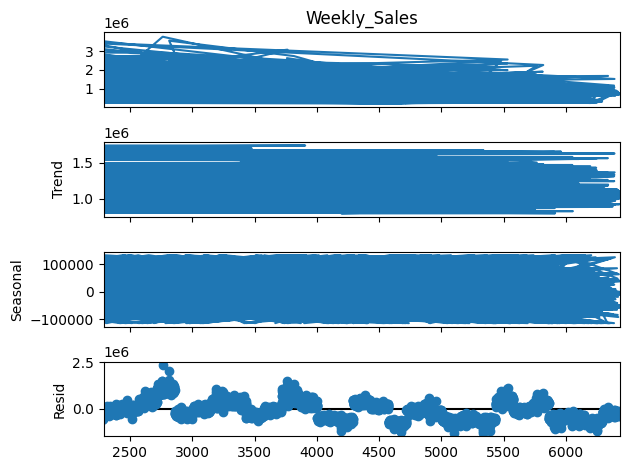

In [17]:
result = seasonal_decompose(df['Weekly_Sales'], model='additive', period=52) # yearly seasonality
result.plot()
plt.show()

#  Plot Trend, Seasonality, Residual separately

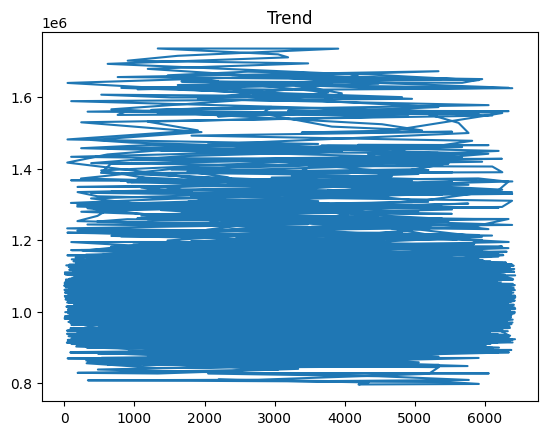

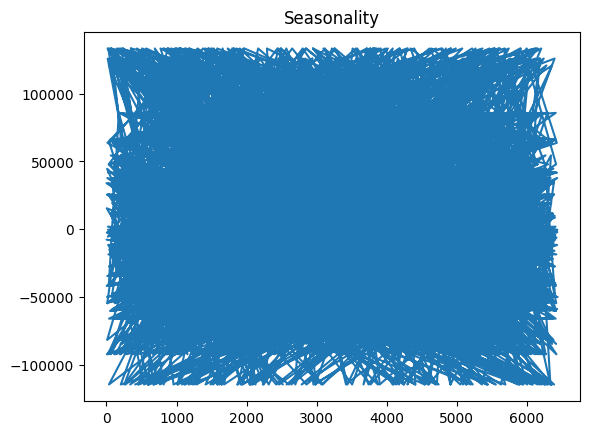

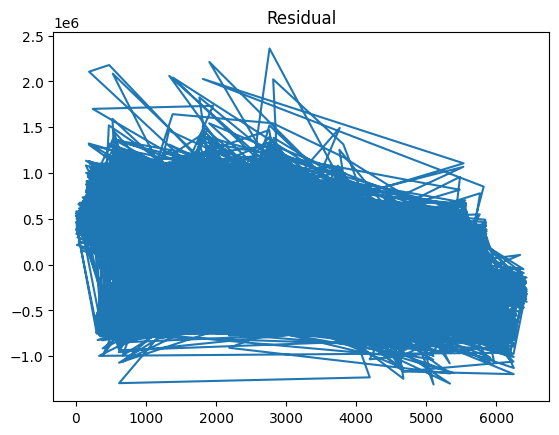

In [23]:
result.trend.plot(title='Trend')
plt.show()
result.seasonal.plot(title='Seasonality')
plt.show()
result.resid.plot(title='Residual')
plt.show()

# Clustering (KMeans)

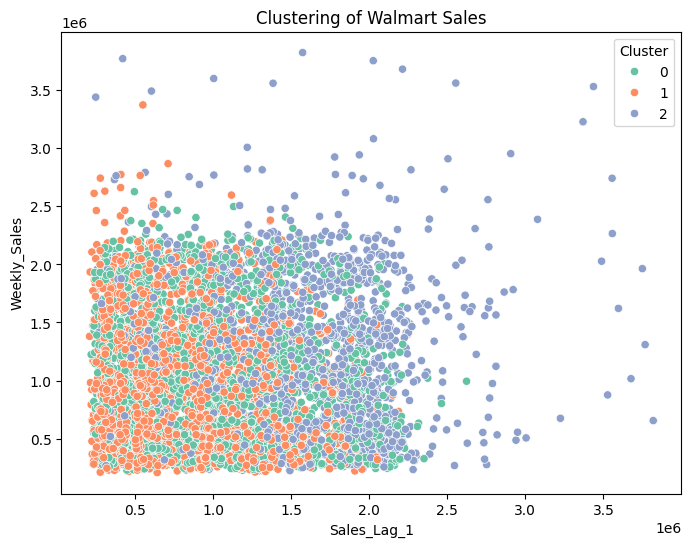

In [19]:
features_cluster = ['Year','Month','WeekOfYear','DayOfWeek','Sales_Lag_1','Sales_Lag_2','Rolling_Mean_4']
X_cluster = df[features_cluster]

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Sales_Lag_1'], y=df['Weekly_Sales'], hue=df['Cluster'], palette='Set2')
plt.title('Clustering of Walmart Sales')
plt.show()

# PCA

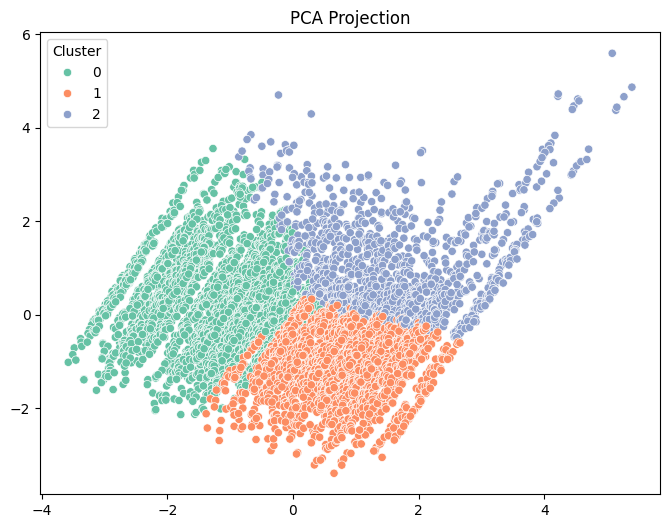

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'][:len(X_pca)], palette='Set2')
plt.title('PCA Projection')
plt.show()

# 13. ROC Curve Example

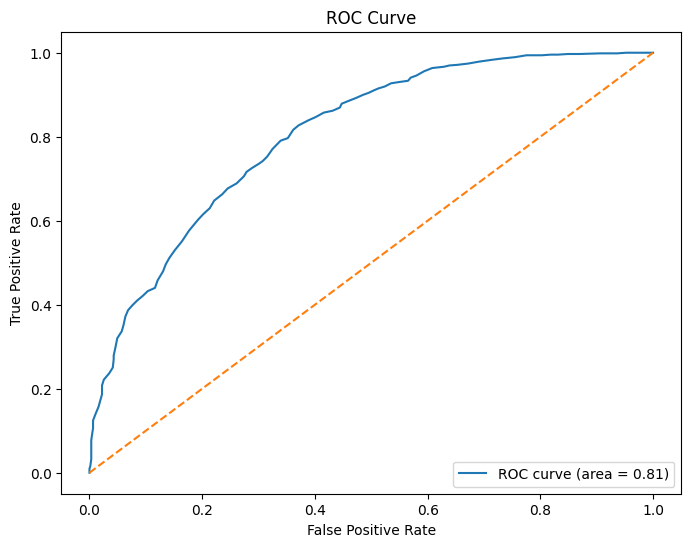

In [29]:
y_class = (y > y.median()).astype(int)
y_train_c, y_test_c = train_test_split(y_class, test_size=0.2, shuffle=False)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train_c)
y_score = clf.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_c, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature Importance Plot for XGBoost

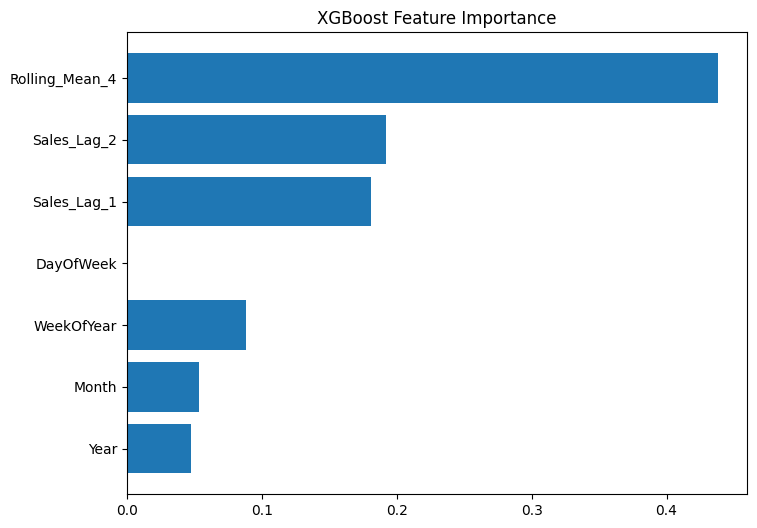

In [25]:
importances = xgb_model.feature_importances_
plt.figure(figsize=(8,6))
plt.barh(features, importances)
plt.title('XGBoost Feature Importance')
plt.show()

# Hyperparameter Tuning for XGBoost using GridSearchCV

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best RMSE: 405352.02113966196


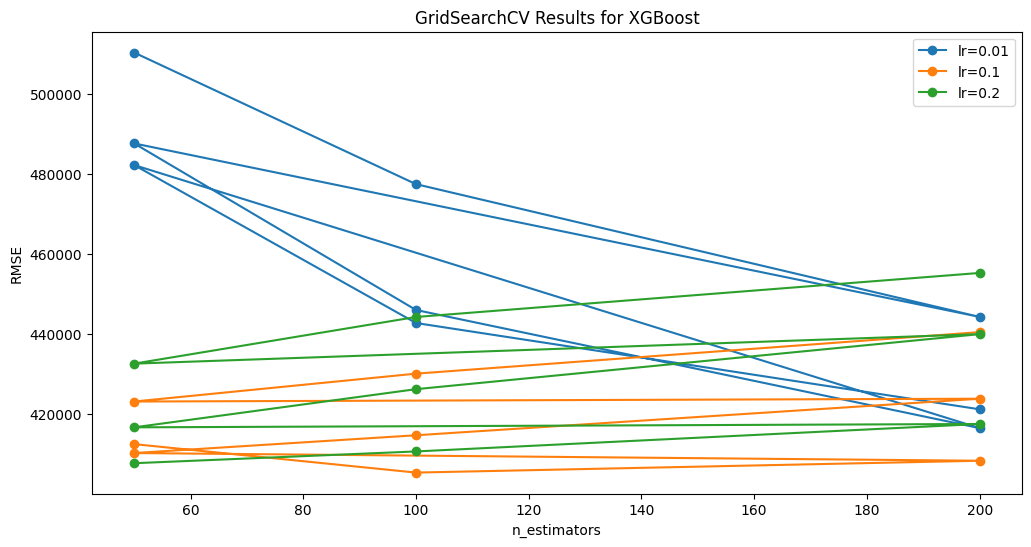

In [28]:
#Hyperparameter Tuning for XGBoost

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42), 
    param_grid, 
    cv=3, 
    scoring='neg_root_mean_squared_error'
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# أفضل Parameters و RMSE
print('Best Parameters:', grid_search.best_params_)
print('Best RMSE:', -grid_search.best_score_)

# ------------------- Plot GridSearch Results -------------------
# نحول النتائج لكائن DataFrame عشان نرسمها
results = pd.DataFrame(grid_search.cv_results_)

# Plot RMSE لكل n_estimators مع max_depth و learning_rate مختلفة
plt.figure(figsize=(12,6))
for lr in param_grid['learning_rate']:
    subset = results[results['param_learning_rate'] == lr]
    plt.plot(subset['param_n_estimators'], -subset['mean_test_score'], marker='o', label=f'lr={lr}')

plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('GridSearchCV Results for XGBoost')
plt.legend()
plt.show()